In [1]:
import pandas as pd
import numpy as np
import sys
import requests
import pprint

import datetime
import pytz
import importlib
import matplotlib.pyplot as plt

import datetime, json, math
from google.cloud import bigquery
from numpy_ext import rolling_apply as rolling_apply_ext

In [2]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)

import os

if os.path.exists('credential.json'):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')
    os.environ["GOOGLE_CLOUD_PROJECT"] = "trading-290017"
else:
    print('the credential.json file does not exist')

import importlib

In [3]:
import market_data.ingest.bq.cache
importlib.reload(market_data.ingest.bq.common)
importlib.reload(market_data.ingest.bq.cache)

<module 'market_data.ingest.bq.cache' from '/Users/junlim/projects/jitter_recovery/market_data/ingest/bq/cache.py'>

In [18]:
import seaborn as sb

In [4]:
date_str_from='2024-04-01'
date_str_to='2024-04-14'
dataset_mode = market_data.ingest.bq.common.DATASET_MODE.OKX
export_mode = market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE

In [5]:
df = market_data.ingest.bq.cache.fetch_and_cache(
    dataset_mode, 
    export_mode, 
    market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from=date_str_from, date_str_to=date_str_to).reset_index()
df_close = df.pivot(index='timestamp', columns='symbol', values='close')
dfi = df.set_index(['timestamp', 'symbol'])

In [14]:
df_close_pct_change = df_close.pct_change()

In [29]:
df_close_pct_change_shifted = df_close_pct_change.shift()

In [16]:
df_close_pct_change.apply(lambda col: col.autocorr(lag=1), axis=0).sort_values()

symbol
USDC-USDT-SWAP    -0.376757
FITFI-USDT-SWAP   -0.291297
LOOKS-USDT-SWAP   -0.282109
EGLD-USDT-SWAP    -0.267351
ARB-USDT-SWAP     -0.222222
                     ...   
XTZ-USDT-SWAP      0.039519
TRX-USD-SWAP       0.042506
BAND-USDT-SWAP     0.042663
TRX-USDT-SWAP      0.053732
FLR-USDT-SWAP      0.060982
Length: 217, dtype: float64

In [19]:
df_corr = df_close_pct_change.corr()

In [31]:
df_close_pct_change.corrwith(df_close_pct_change_shifted).sort_values()

symbol
USDC-USDT-SWAP    -0.376757
FITFI-USDT-SWAP   -0.291297
LOOKS-USDT-SWAP   -0.282109
EGLD-USDT-SWAP    -0.267351
ARB-USDT-SWAP     -0.222222
                     ...   
XTZ-USDT-SWAP      0.039519
TRX-USD-SWAP       0.042506
BAND-USDT-SWAP     0.042663
TRX-USDT-SWAP      0.053732
FLR-USDT-SWAP      0.060982
Length: 217, dtype: float64

In [36]:
df_corrwith_shifted = df_close_pct_change.apply(lambda s: df_close_pct_change_shifted.corrwith(s))

In [26]:
df_corr.xs('BTC-USDT-SWAP').sort_values()

symbol
USDC-USDT-SWAP     0.034876
BLOCK-USDT-SWAP    0.039543
VENOM-USDT-SWAP    0.081987
ZEUS-USDT-SWAP     0.167894
GF-USDT-SWAP       0.175812
                     ...   
ETH-USD-SWAP       0.824715
ETH-USDT-SWAP      0.831179
BTC-USDC-SWAP      0.963839
BTC-USD-SWAP       0.990609
BTC-USDT-SWAP      1.000000
Name: BTC-USDT-SWAP, Length: 217, dtype: float64

<AxesSubplot:xlabel='symbol', ylabel='symbol'>

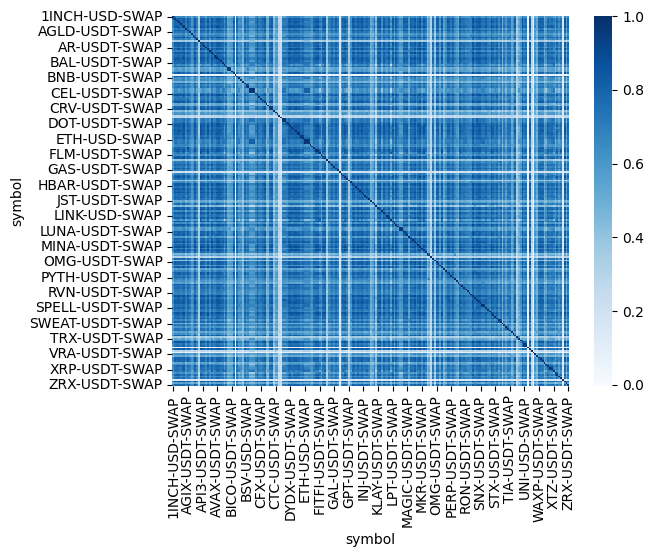

In [21]:
sb.heatmap(df_corr, cmap="Blues", annot=False)

In [38]:
df_corrwith_shifted.xs('BTC-USDT-SWAP').sort_values()

symbol
JUP-USDT-SWAP     -0.057357
LOOKS-USDT-SWAP   -0.050718
JTO-USDT-SWAP     -0.043256
YGG-USDT-SWAP     -0.040502
FRONT-USDT-SWAP   -0.037067
                     ...   
BLOCK-USDT-SWAP    0.139036
DGB-USDT-SWAP      0.141295
VENOM-USDT-SWAP    0.141427
XLM-USD-SWAP       0.154965
GF-USDT-SWAP       0.193781
Name: BTC-USDT-SWAP, Length: 217, dtype: float64

In [39]:
df_corrwith_shifted.xs('1INCH-USDT-SWAP').sort_values()

symbol
BIGTIME-USDT-SWAP   -0.134695
LOOKS-USDT-SWAP     -0.117756
JUP-USDT-SWAP       -0.116101
APE-USDT-SWAP       -0.106563
ZIL-USDT-SWAP       -0.105626
                       ...   
CSPR-USDT-SWAP       0.150516
TRX-USD-SWAP         0.163781
BLOCK-USDT-SWAP      0.164151
GF-USDT-SWAP         0.217437
GPT-USDT-SWAP        0.228402
Name: 1INCH-USDT-SWAP, Length: 217, dtype: float64

<AxesSubplot:xlabel='symbol'>

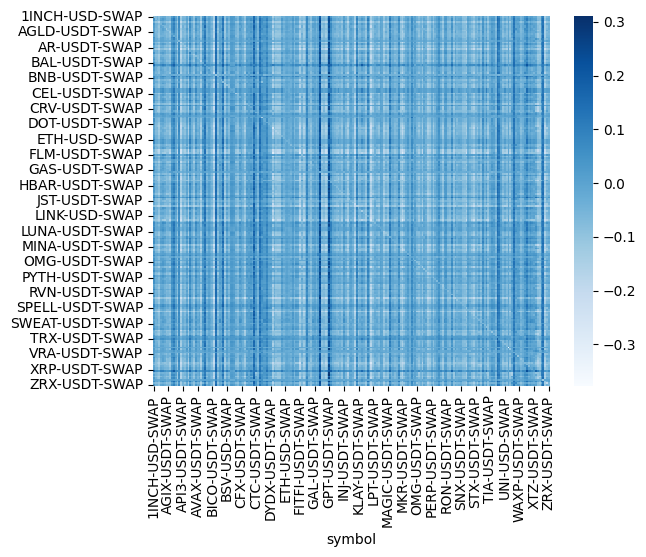

In [37]:
sb.heatmap(df_corrwith_shifted, cmap="Blues", annot=False)